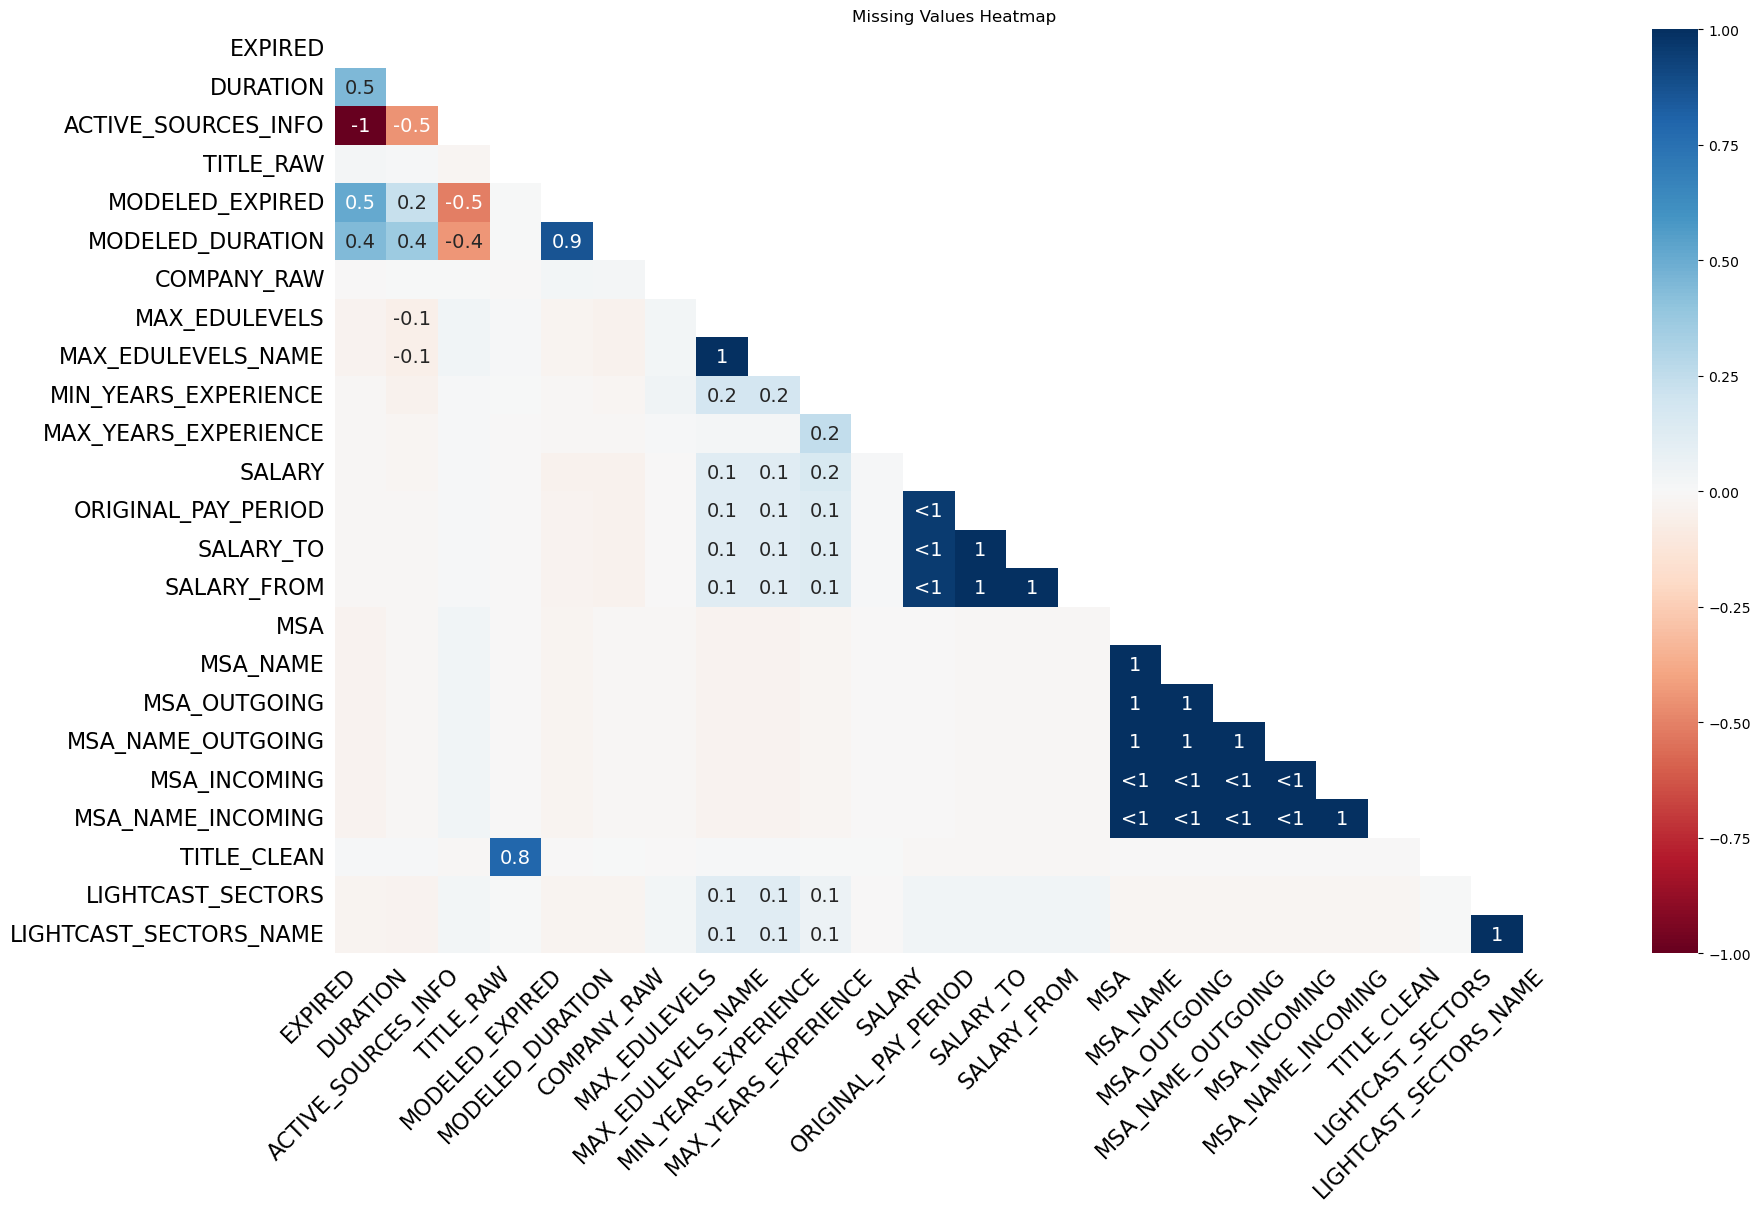

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import missingno as msno

df = pd.read_csv("data/lightcast_job_postings.csv")

columns_to_keep = [
    'COMPANY_RAW',                # company
    'EDUCATION_LEVELS',           # education
    'MIN_YEARS_EXPERIENCE',
    'MAX_YEARS_EXPERIENCE',        # experience
    'TITLE_CLEAN',                # job title
    'SKILLS',                     # general skills
    'SPECIALIZED_SKILLS',        # specialized skills
    'CERTIFICATIONS',            # certifications
    'COMMON_SKILLS',             # common skills
    'SOFTWARE_SKILLS',           # software skills
    'SOC_2021_4_NAME',           # SOC 2021
    'NAICS_2022_6',              # NAICS 2022
    'REMOTE_TYPE_NAME',          # remote work type
    'SALARY'                     # salary (if present in your dataset)
]

eda_data = df[columns_to_keep]


msno.heatmap(df)
plt.title("Missing Values Heatmap")
plt.show()

In [3]:
eda_data.to_csv('eda_data.csv', index=False)